Training model...
tensor(1.4880, grad_fn=<MeanBackward0>)
tensor(0.4567, grad_fn=<MeanBackward0>)
tensor(0.5869, grad_fn=<MeanBackward0>)
tensor(0.4093, grad_fn=<MeanBackward0>)
tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(0.3484, grad_fn=<MeanBackward0>)
tensor(0.4776, grad_fn=<MeanBackward0>)
tensor(0.6713, grad_fn=<MeanBackward0>)
tensor(0.3369, grad_fn=<MeanBackward0>)
tensor(0.3371, grad_fn=<MeanBackward0>)
tensor(0.3533, grad_fn=<MeanBackward0>)
tensor(0.4718, grad_fn=<MeanBackward0>)
tensor(0.7126, grad_fn=<MeanBackward0>)
tensor(0.4767, grad_fn=<MeanBackward0>)
tensor(0.3801, grad_fn=<MeanBackward0>)
tensor(0.5691, grad_fn=<MeanBackward0>)
tensor(0.3982, grad_fn=<MeanBackward0>)
tensor(0.4562, grad_fn=<MeanBackward0>)
tensor(0.2287, grad_fn=<MeanBackward0>)
tensor(0.4143, grad_fn=<MeanBackward0>)
tensor(0.2238, grad_fn=<MeanBackward0>)


/var/folders/nx/w9zd5lv56xd4swsqzzbj6lsc0000gn/T/ipykernel_86526/2667344532.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.3915, grad_fn=<MeanBackward0>)
tensor(0.3683, grad_fn=<MeanBackward0>)
tensor(0.6667, grad_fn=<MeanBackward0>)
tensor(0.5474, grad_fn=<MeanBackward0>)
tensor(0.3710, grad_fn=<MeanBackward0>)
tensor(0.2499, grad_fn=<MeanBackward0>)
tensor(0.3021, grad_fn=<MeanBackward0>)
tensor(0.3348, grad_fn=<MeanBackward0>)
tensor(0.3958, grad_fn=<MeanBackward0>)
tensor(0.3062, grad_fn=<MeanBackward0>)
tensor(0.4337, grad_fn=<MeanBackward0>)
tensor(0.4209, grad_fn=<MeanBackward0>)
tensor(0.5303, grad_fn=<MeanBackward0>)
tensor(0.3197, grad_fn=<MeanBackward0>)
tensor(0.3086, grad_fn=<MeanBackward0>)
tensor(0.7797, grad_fn=<MeanBackward0>)
tensor(0.2654, grad_fn=<MeanBackward0>)
tensor(0.2991, grad_fn=<MeanBackward0>)
tensor(0.1652, grad_fn=<MeanBackward0>)


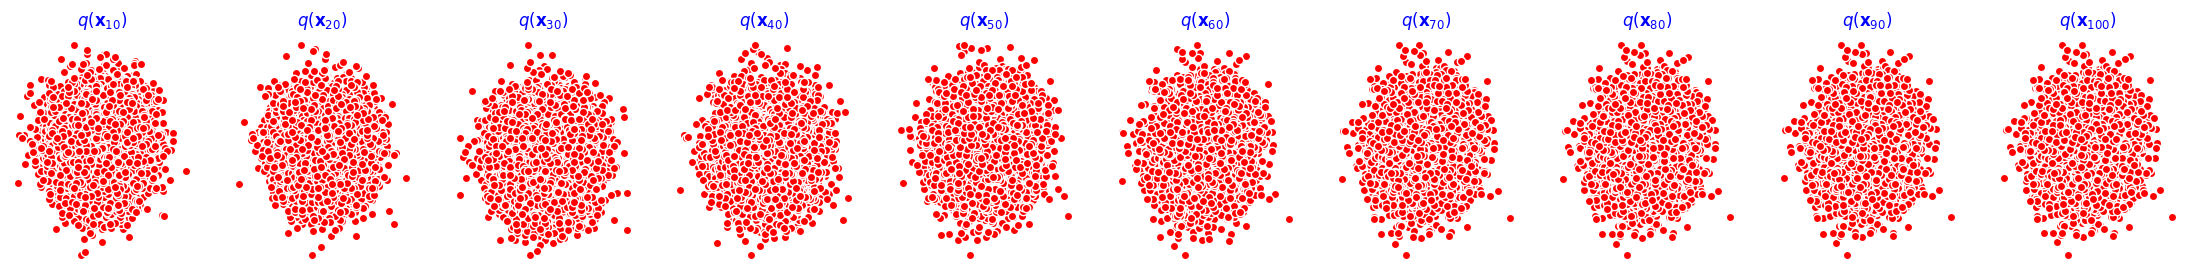

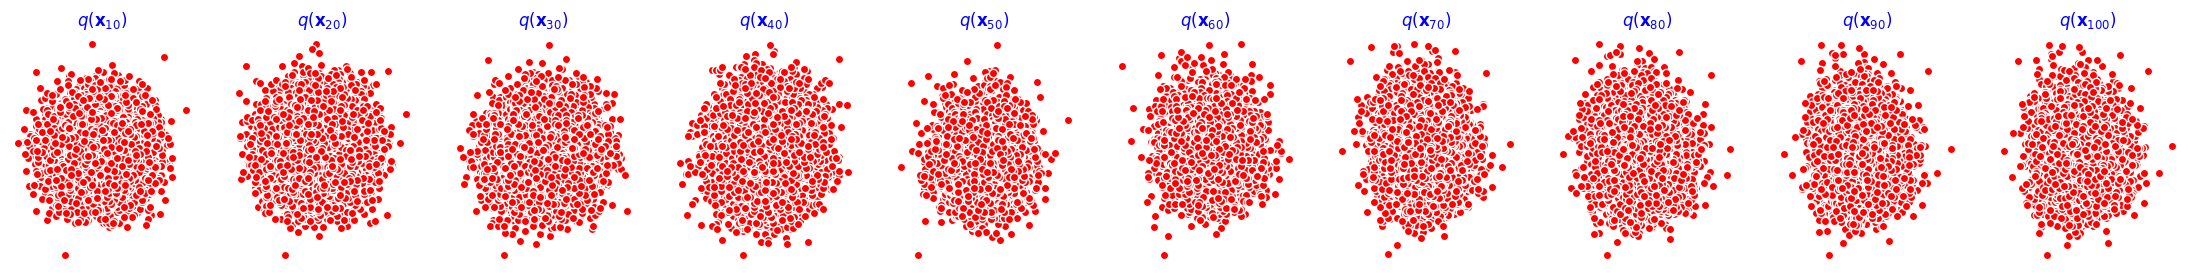

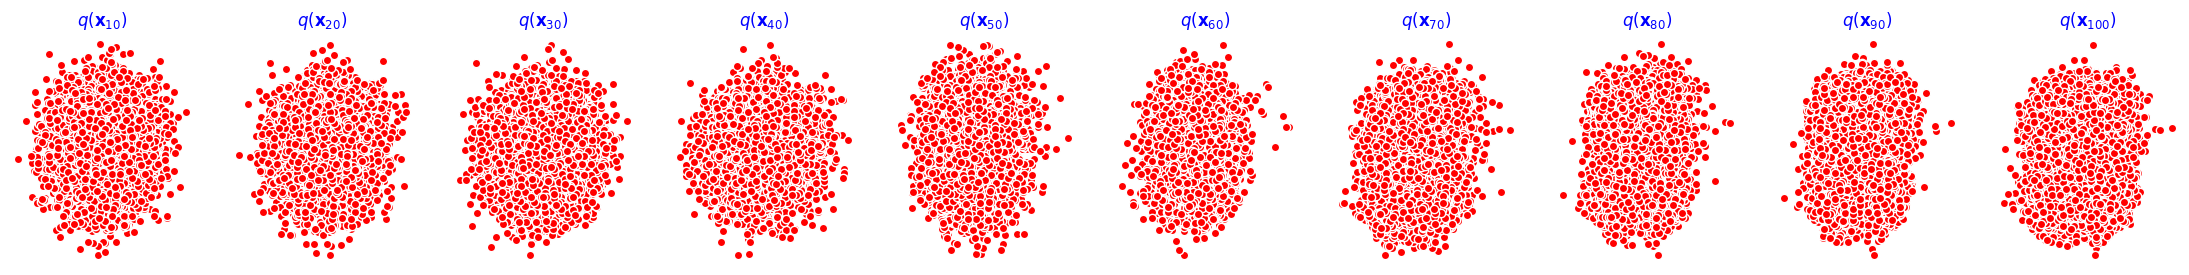

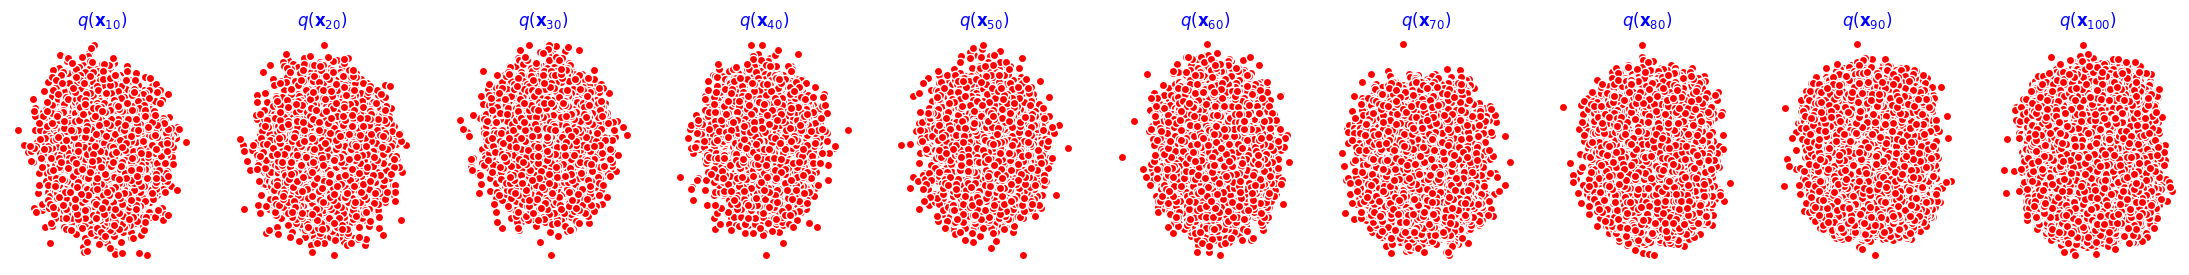

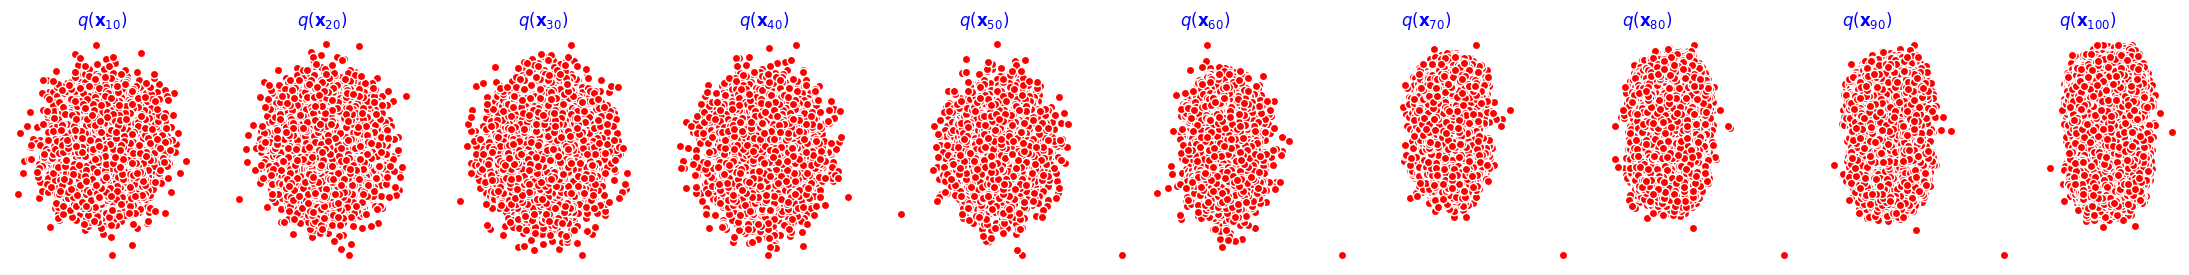

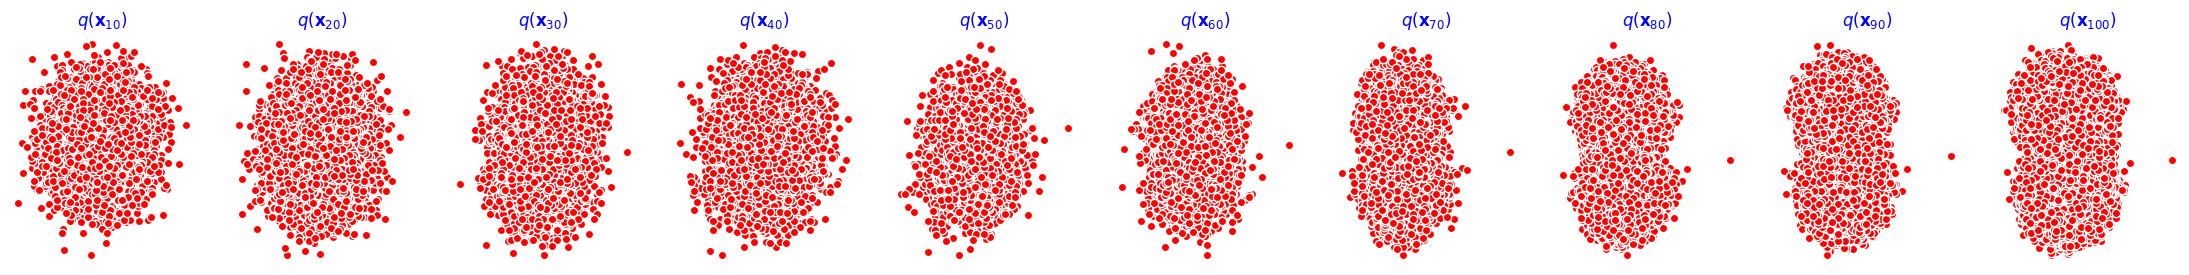

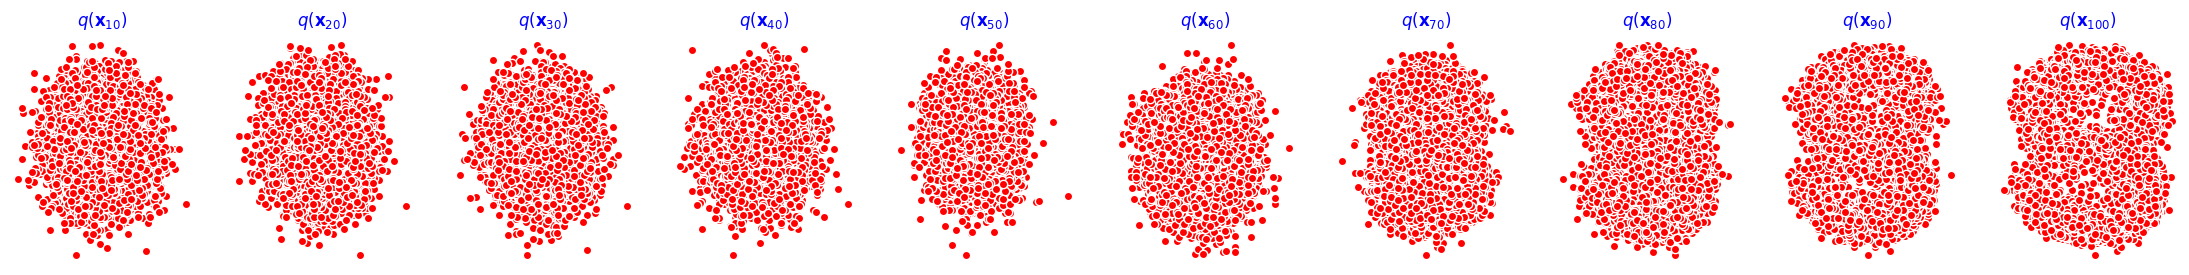

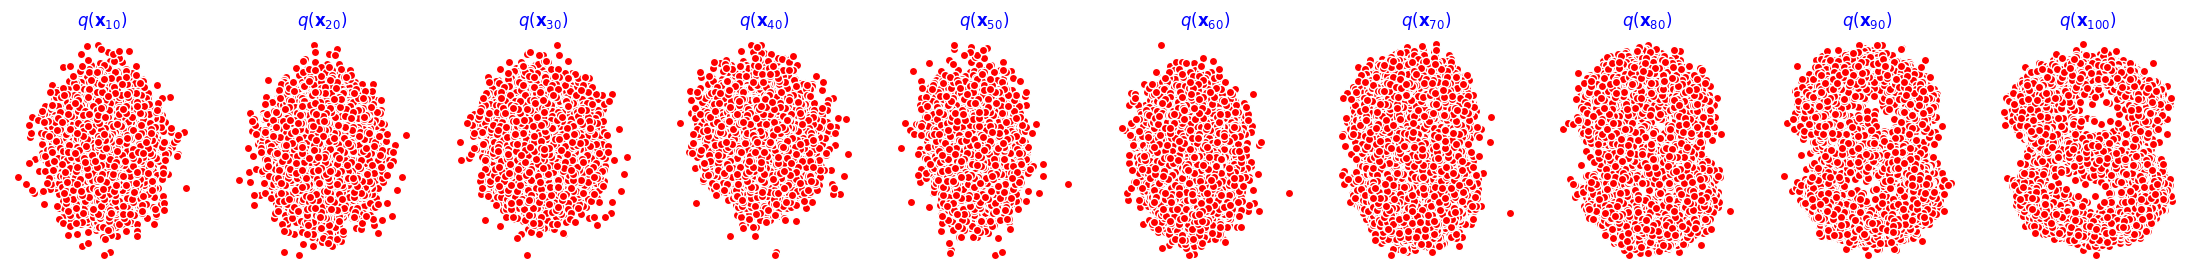

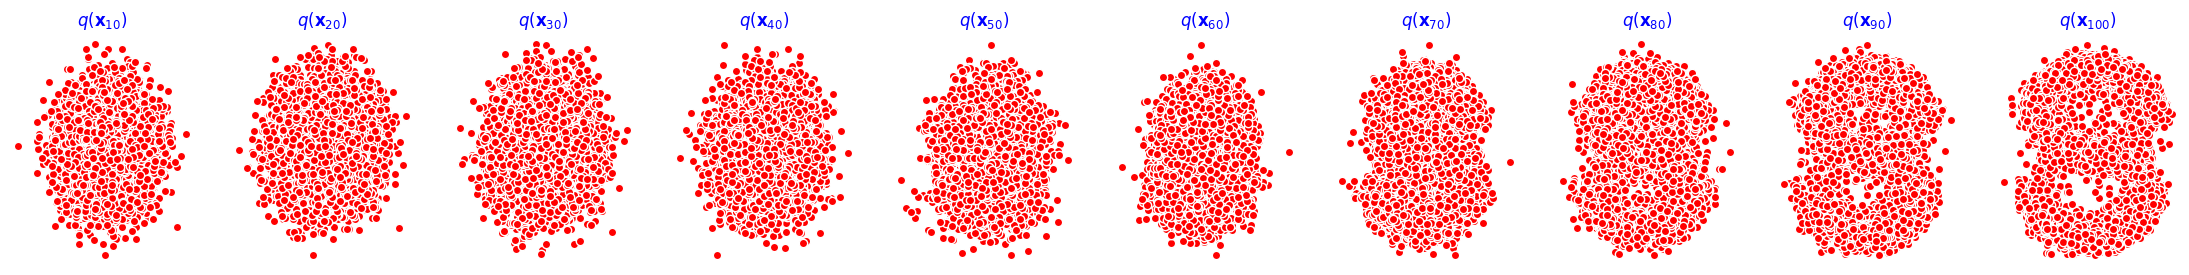

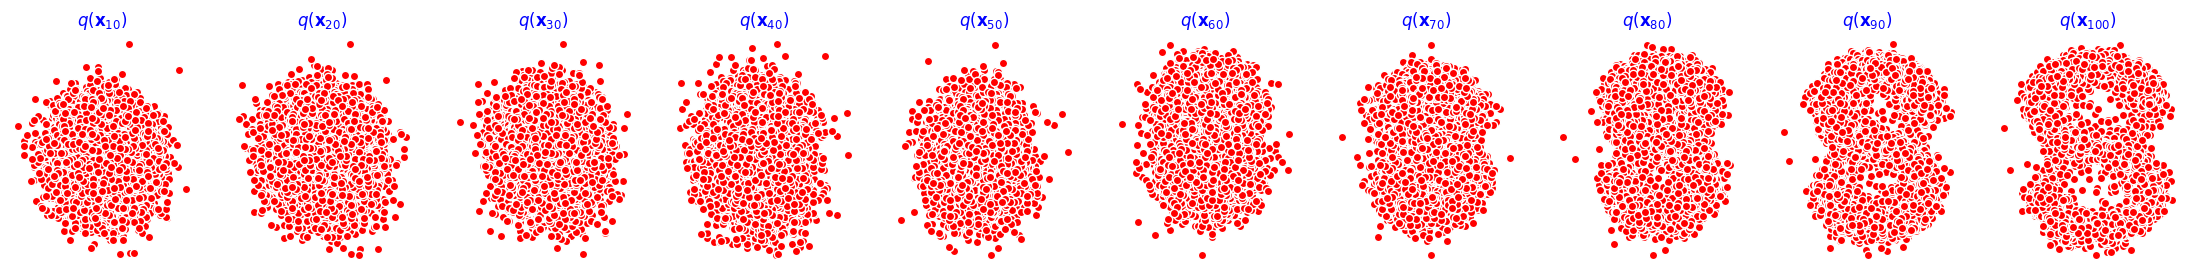

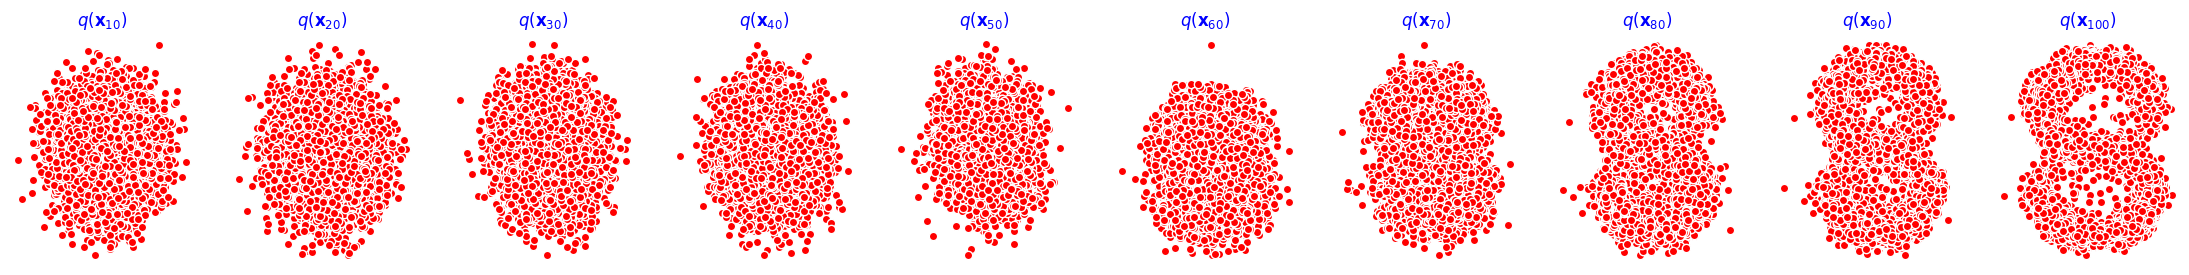

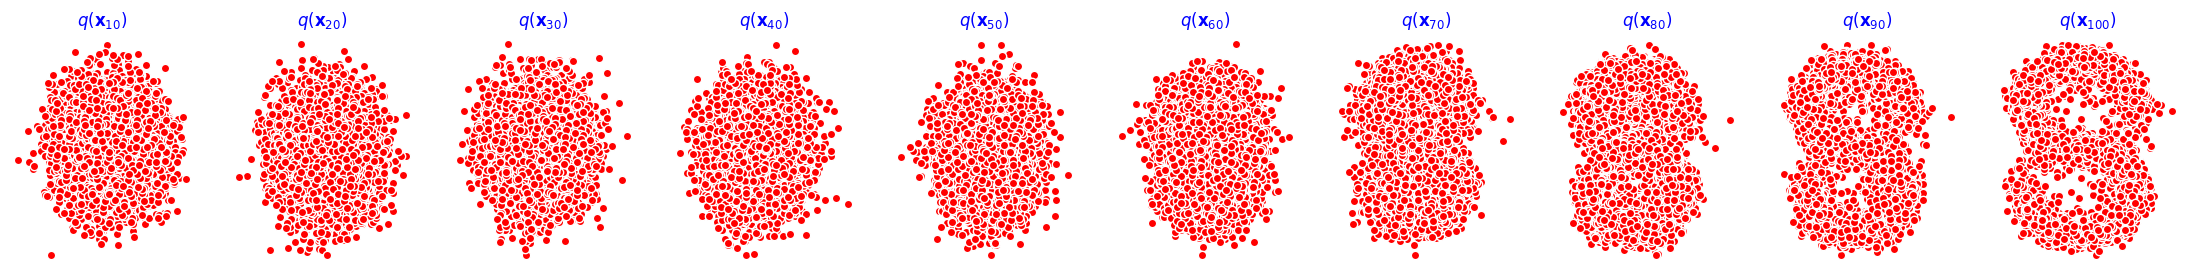

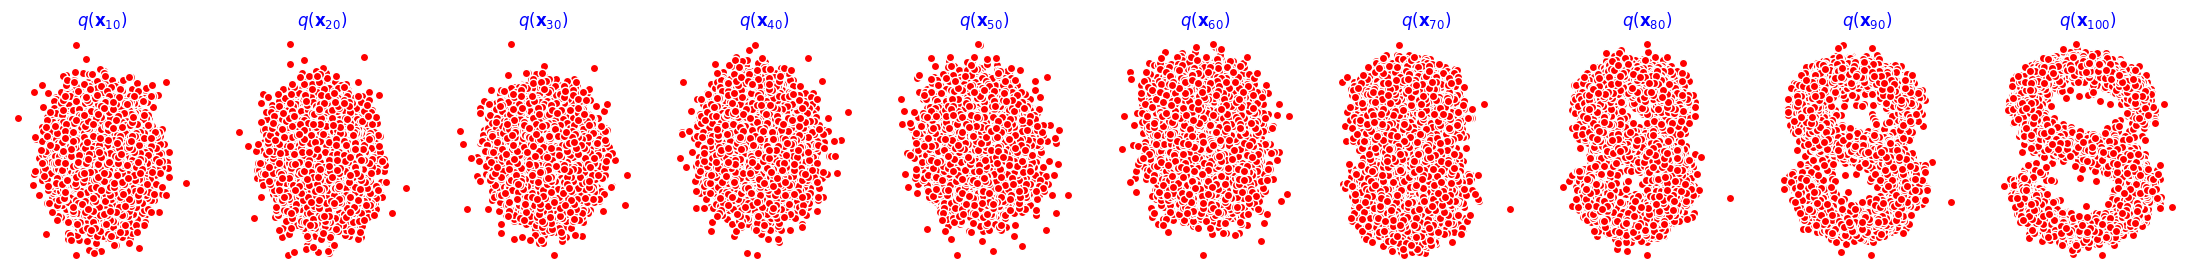

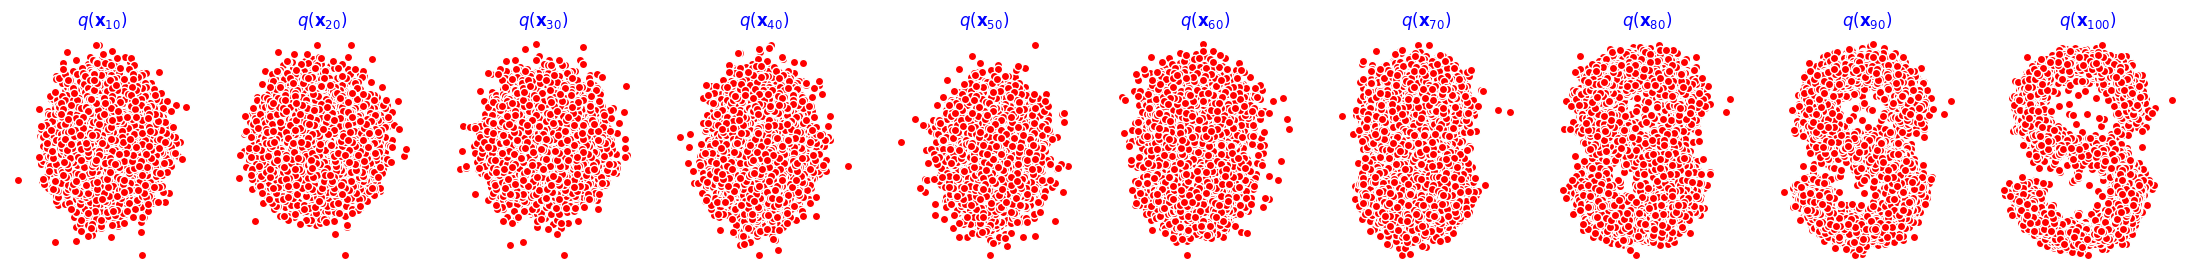

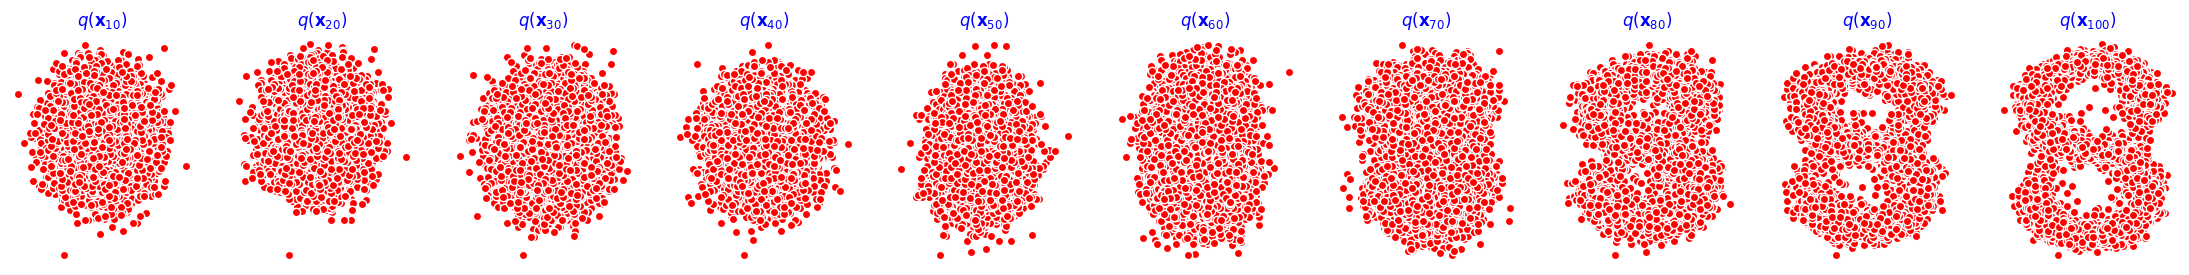

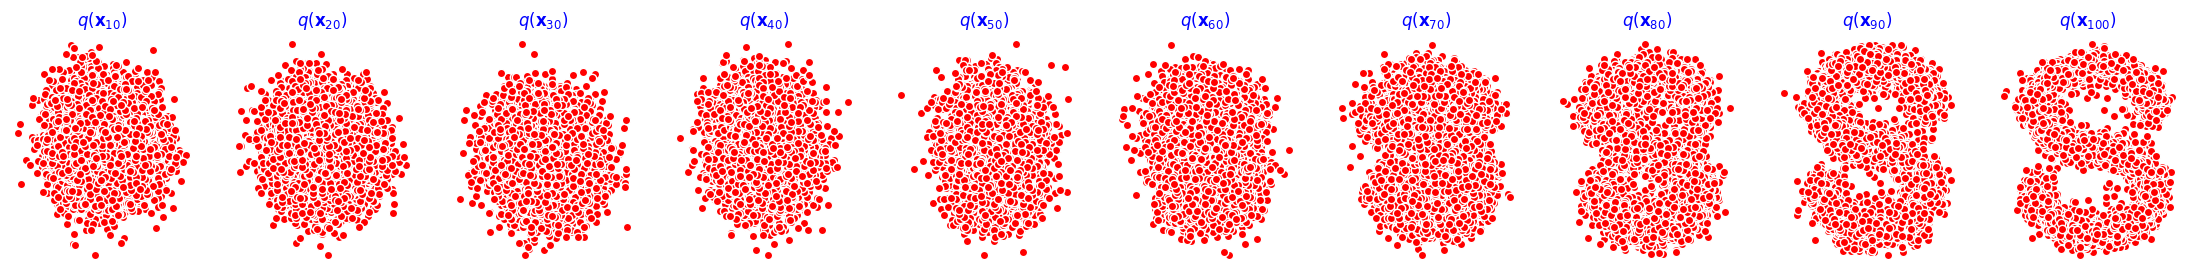

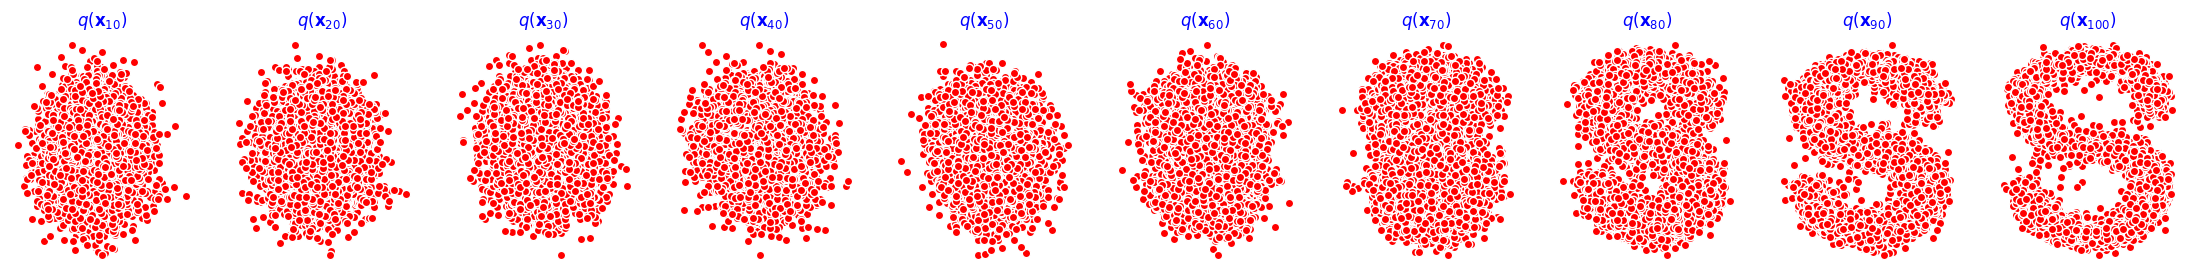

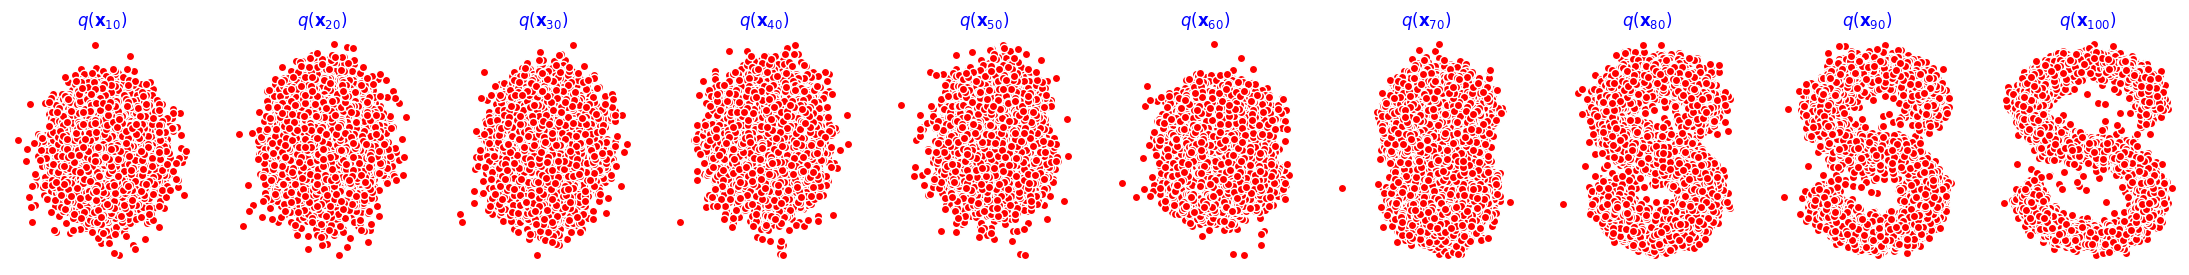

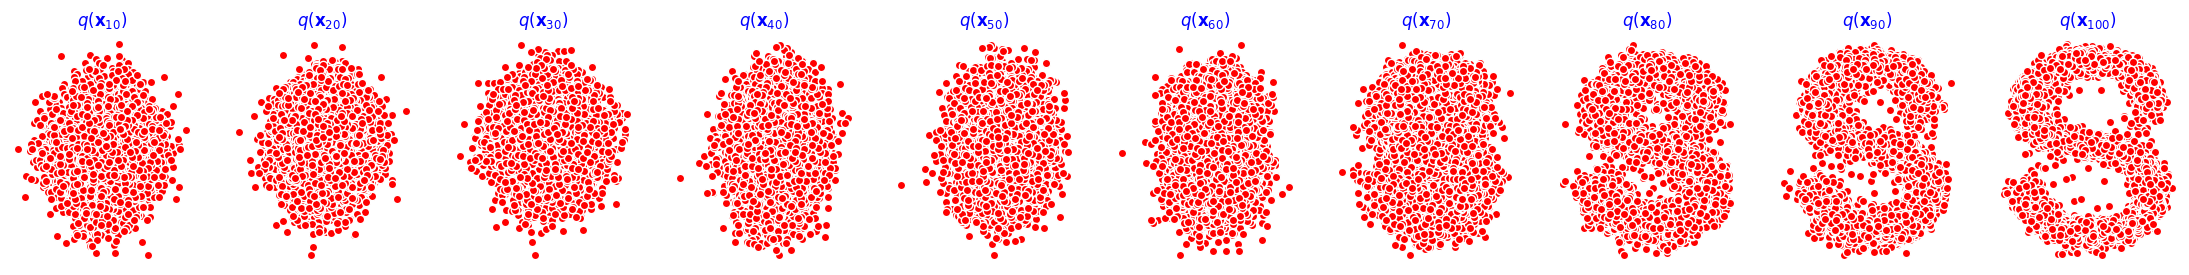

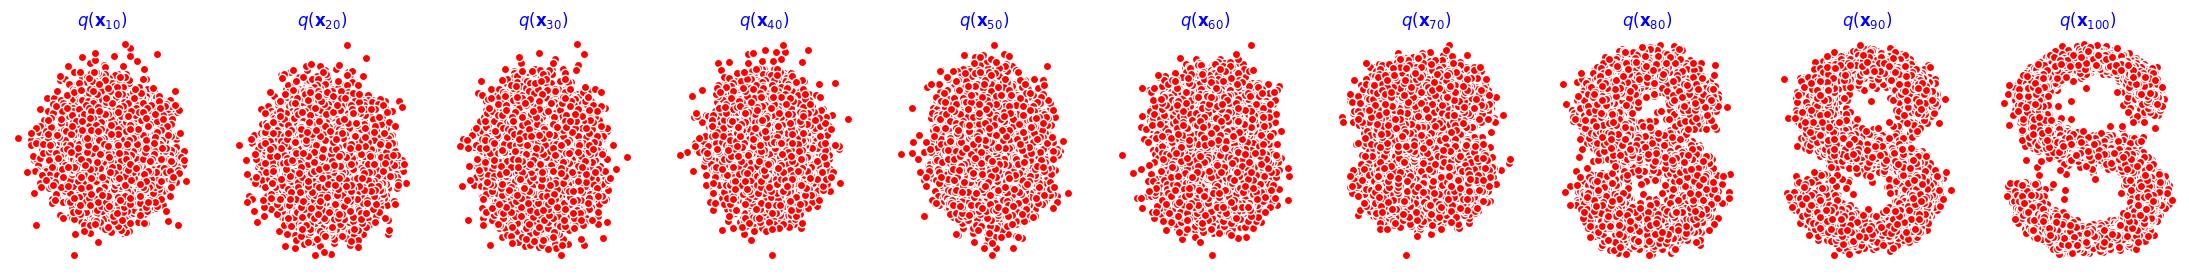

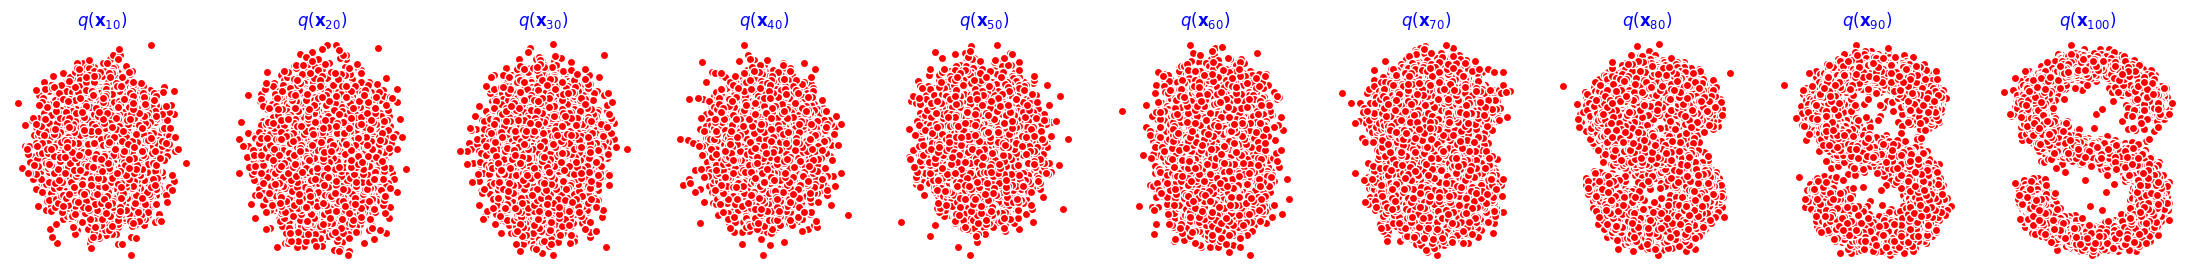

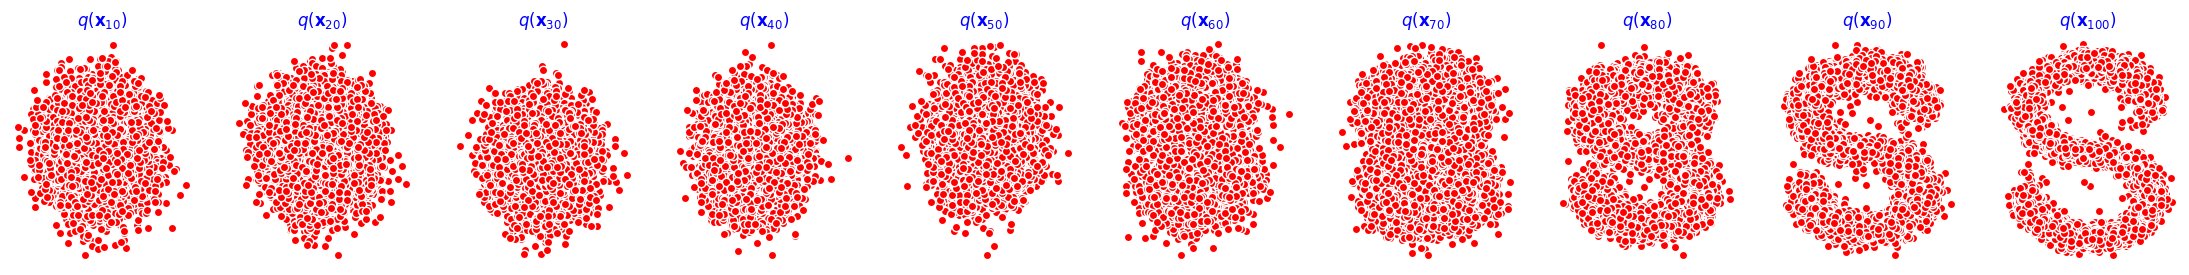

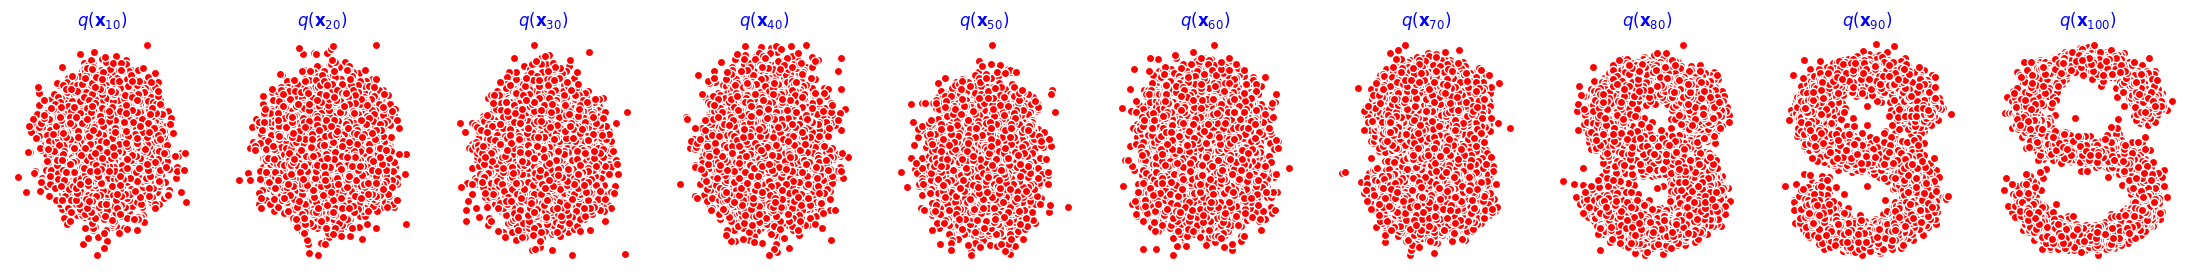

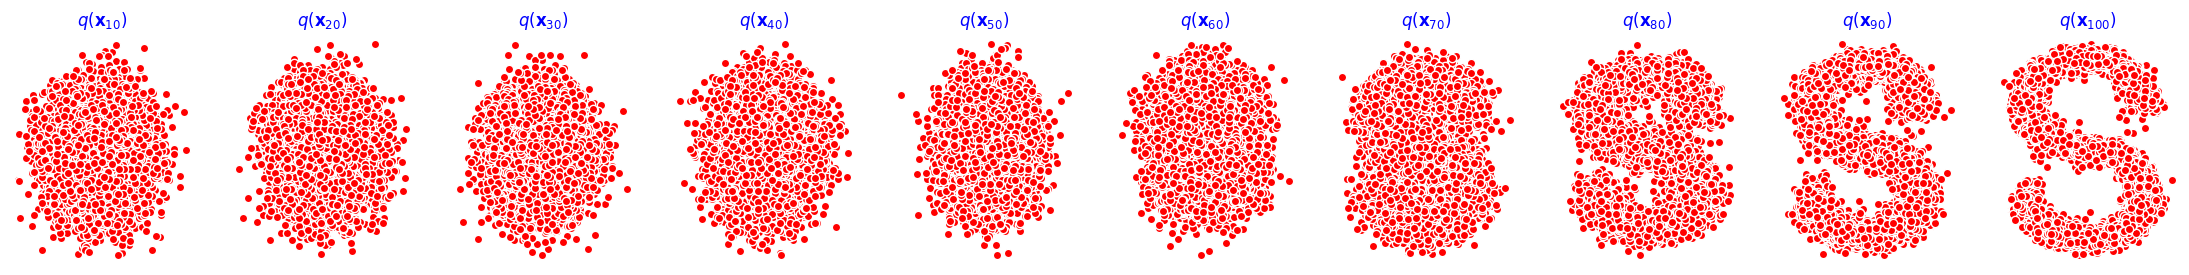

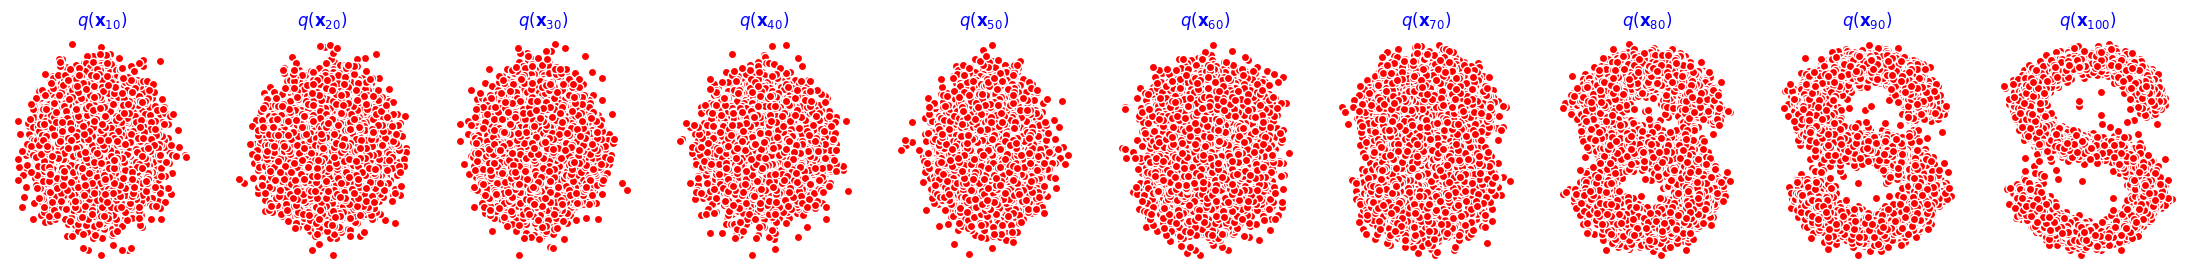

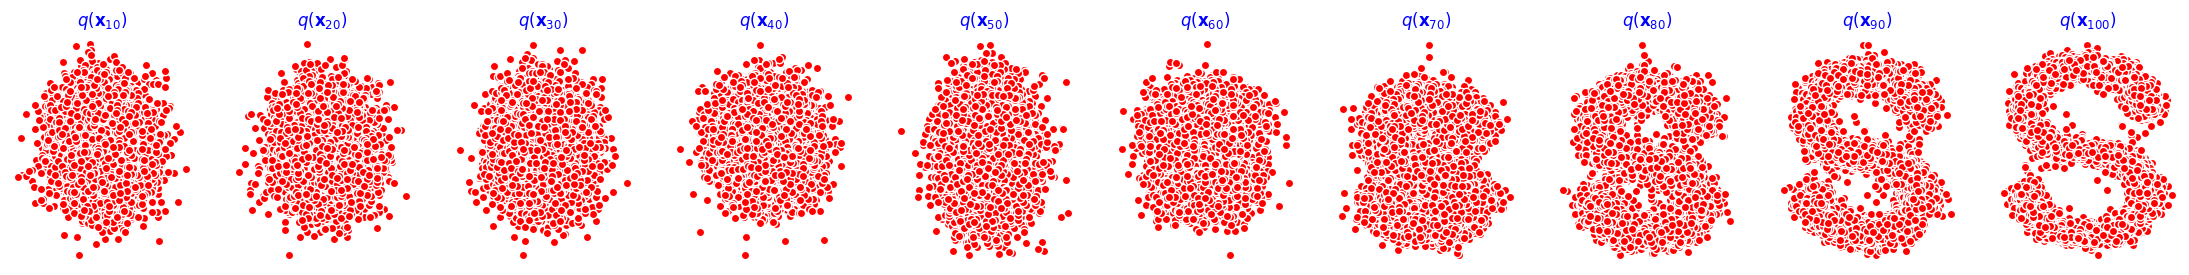

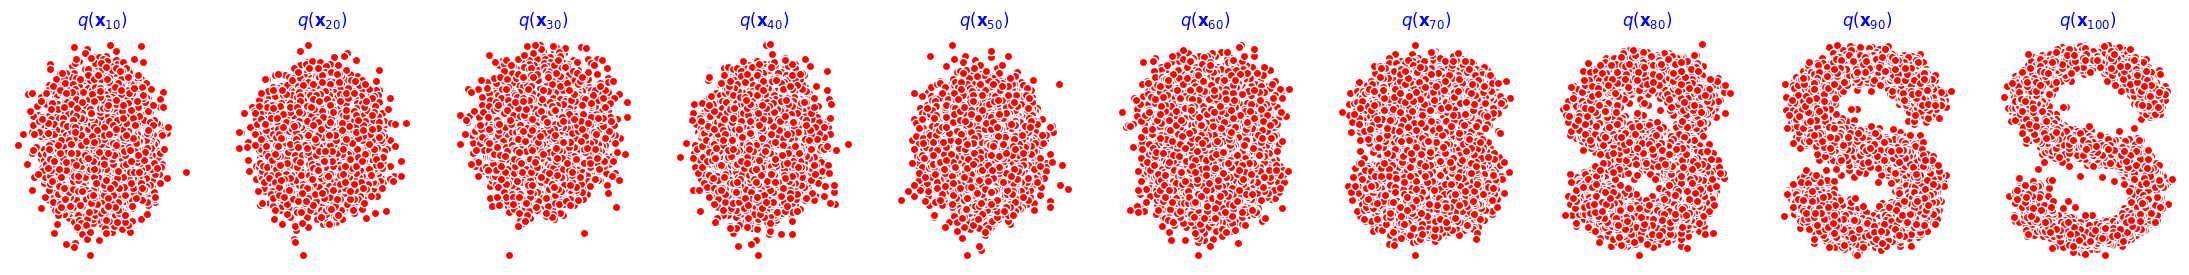

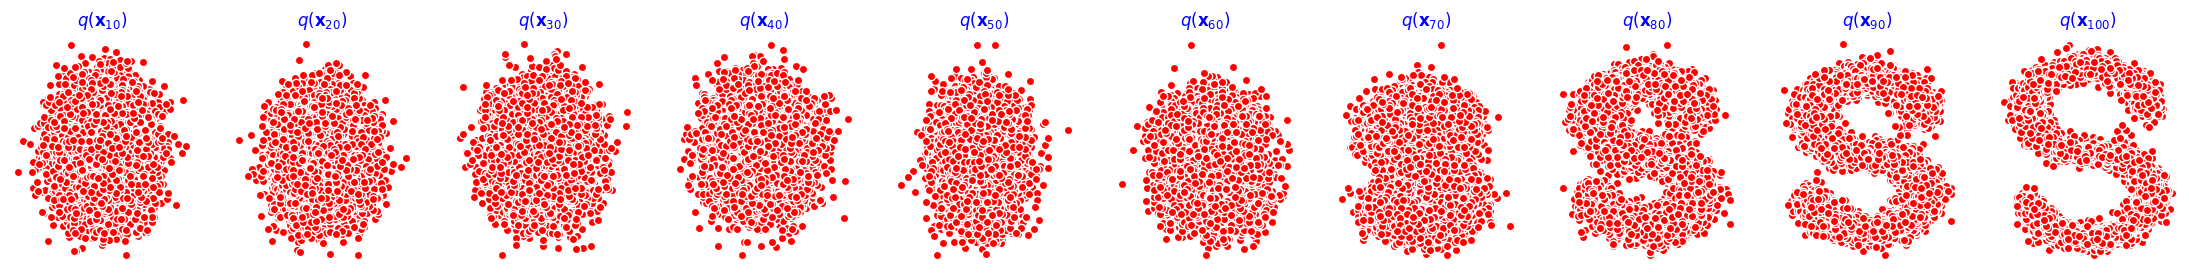

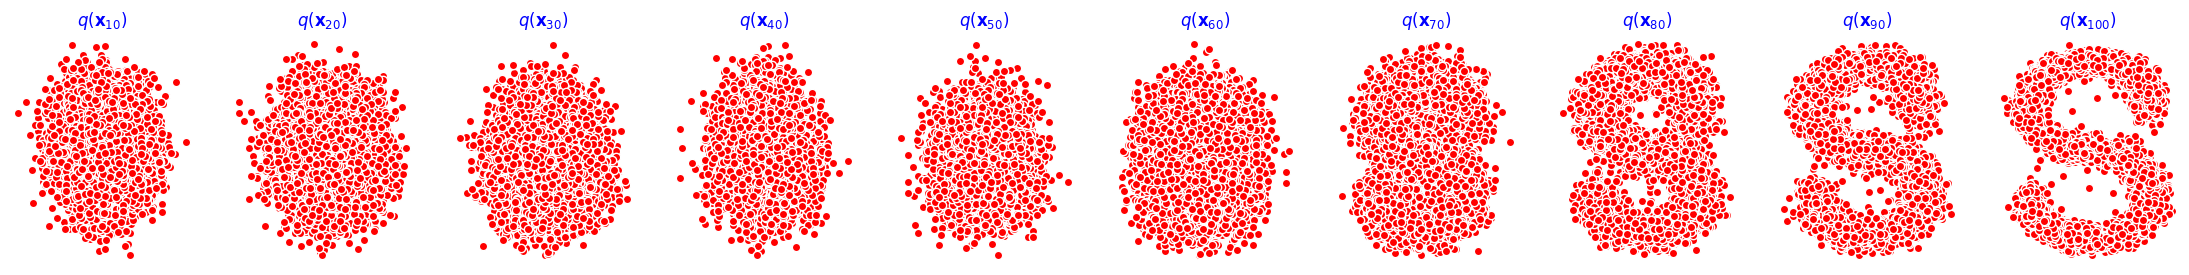

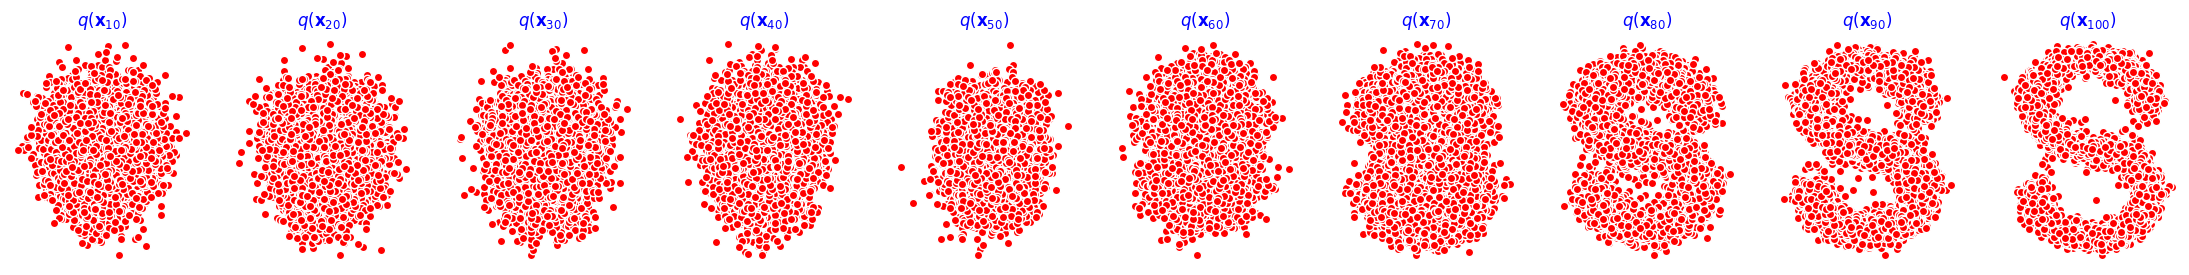

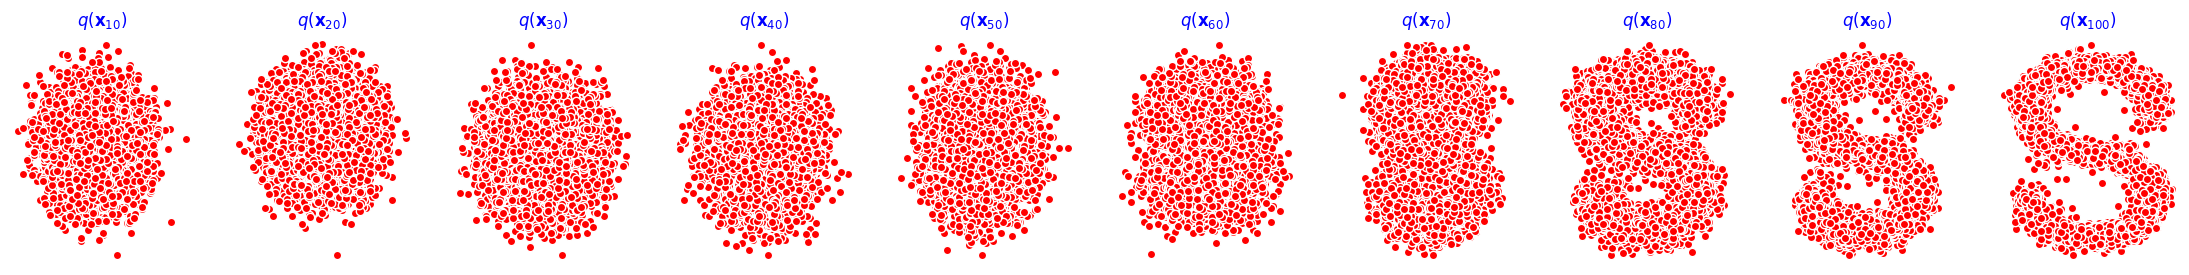

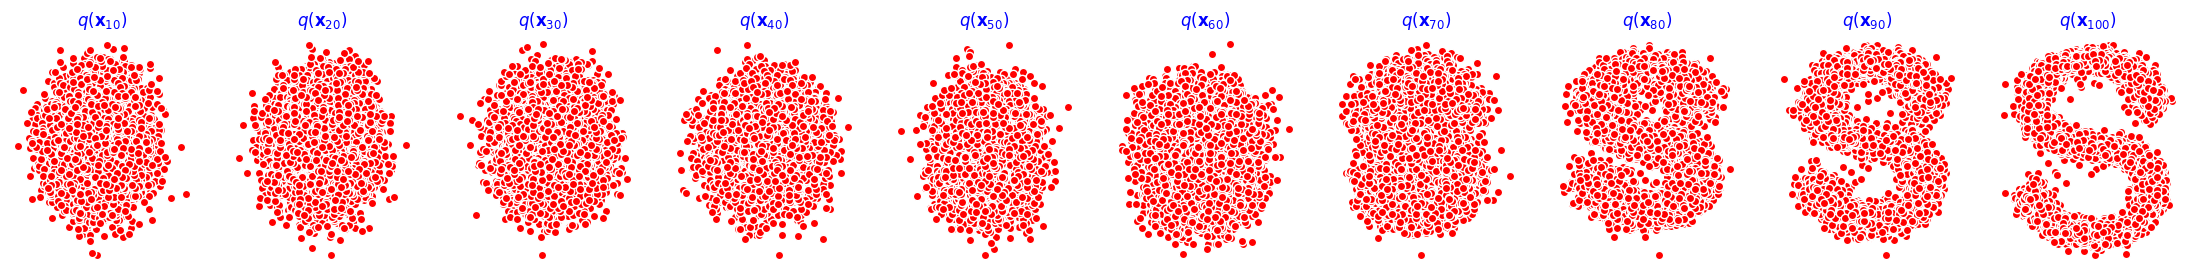

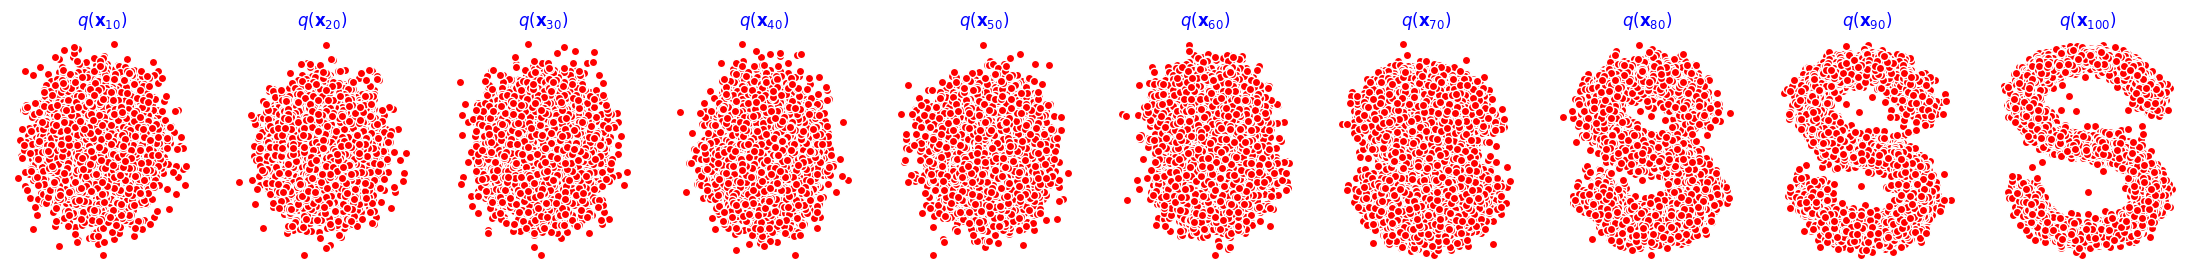

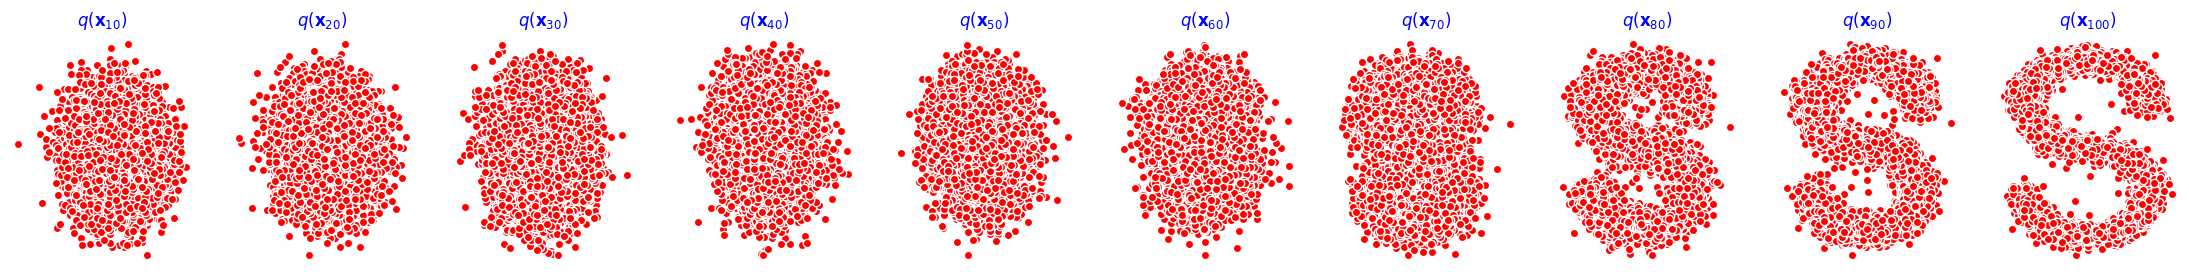

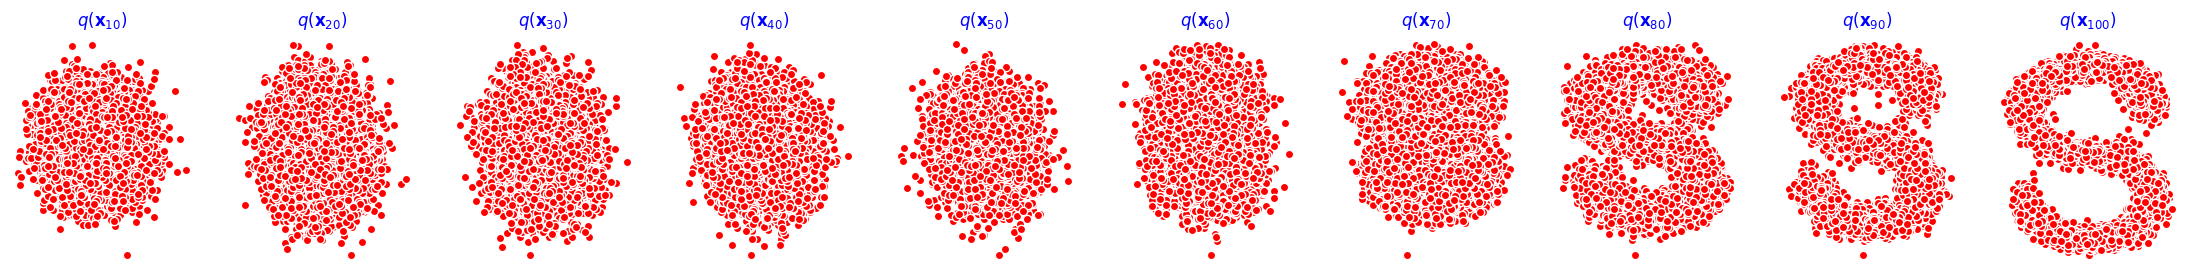

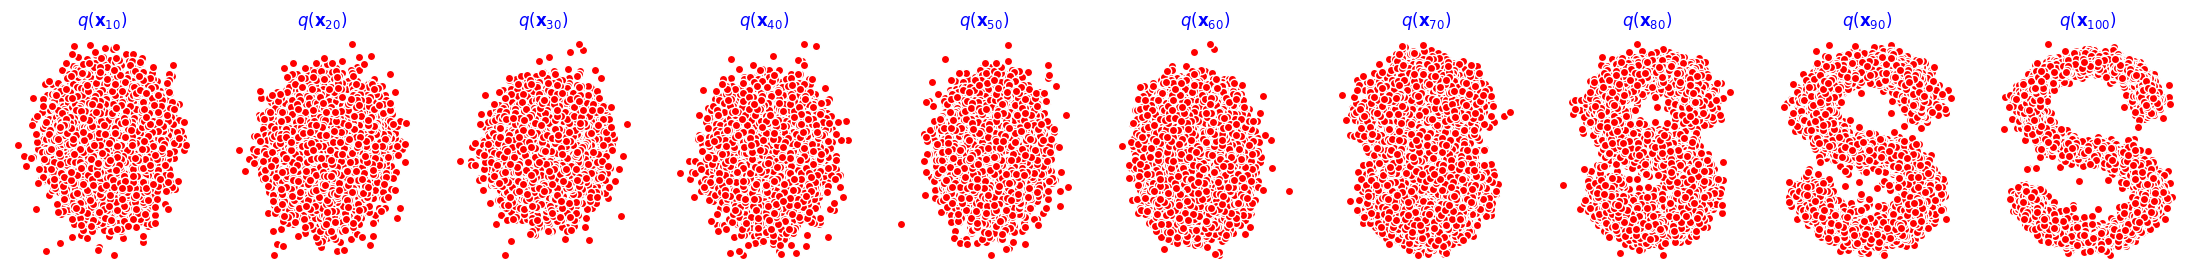

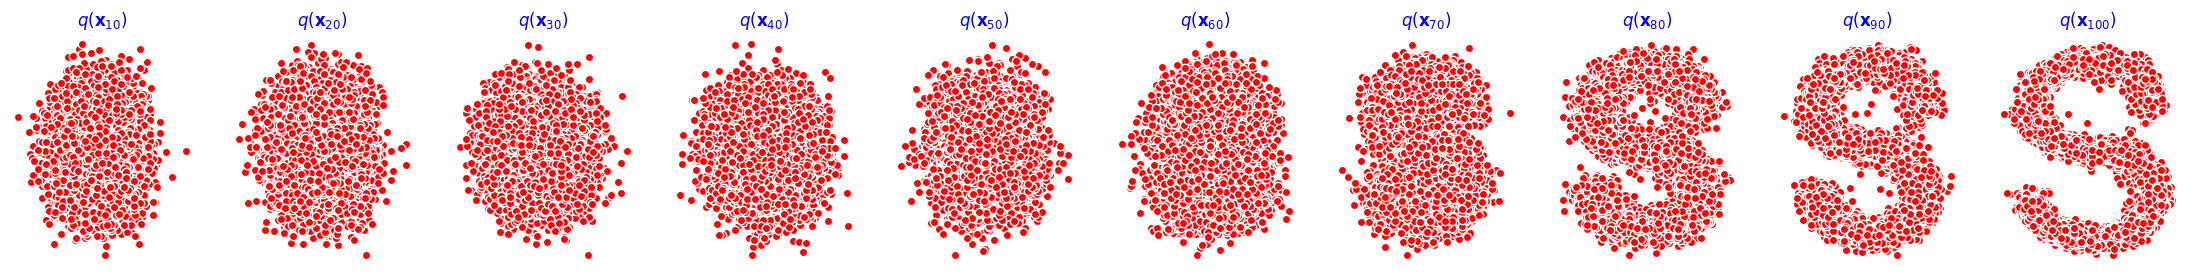

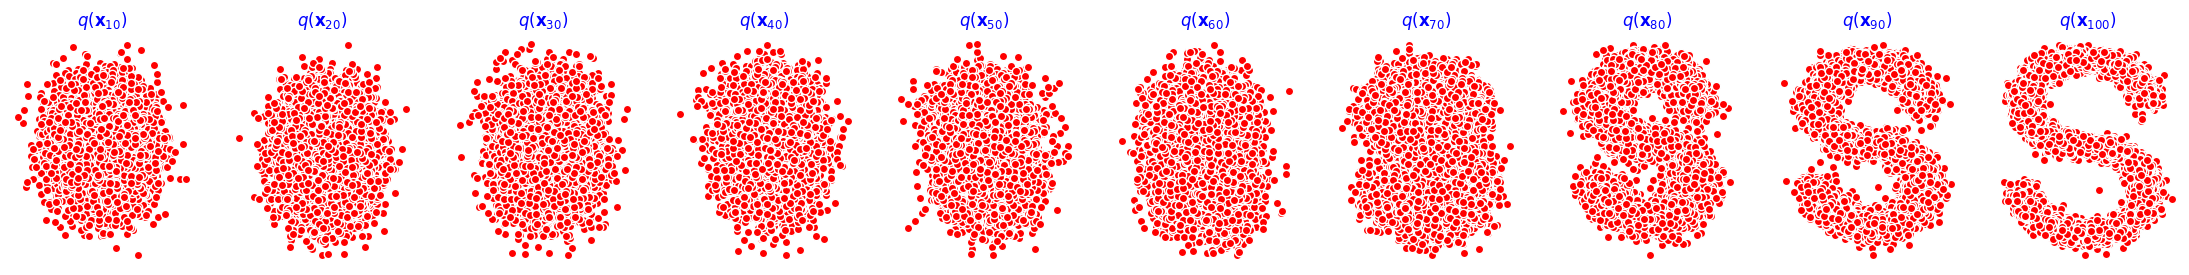

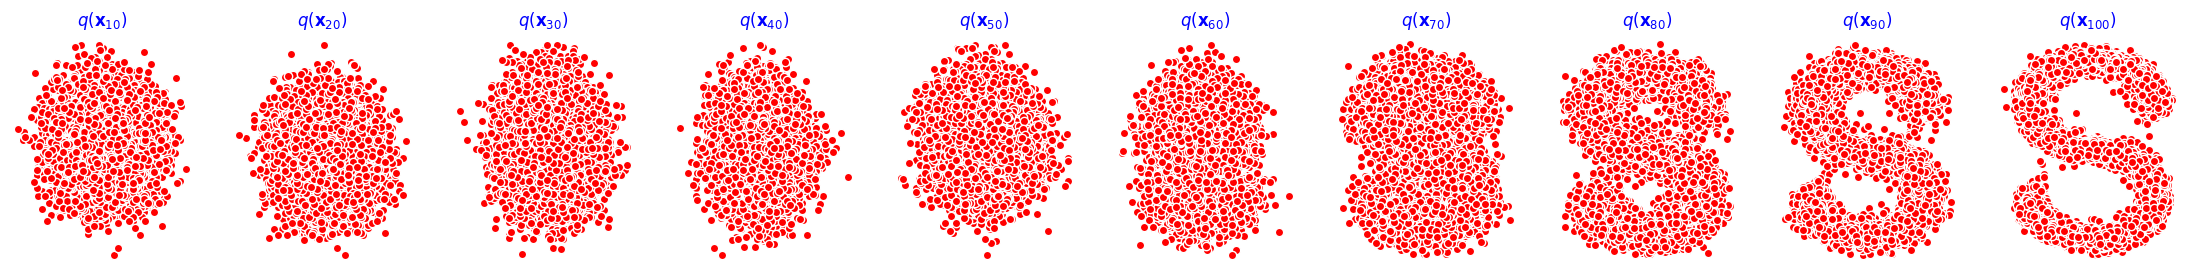

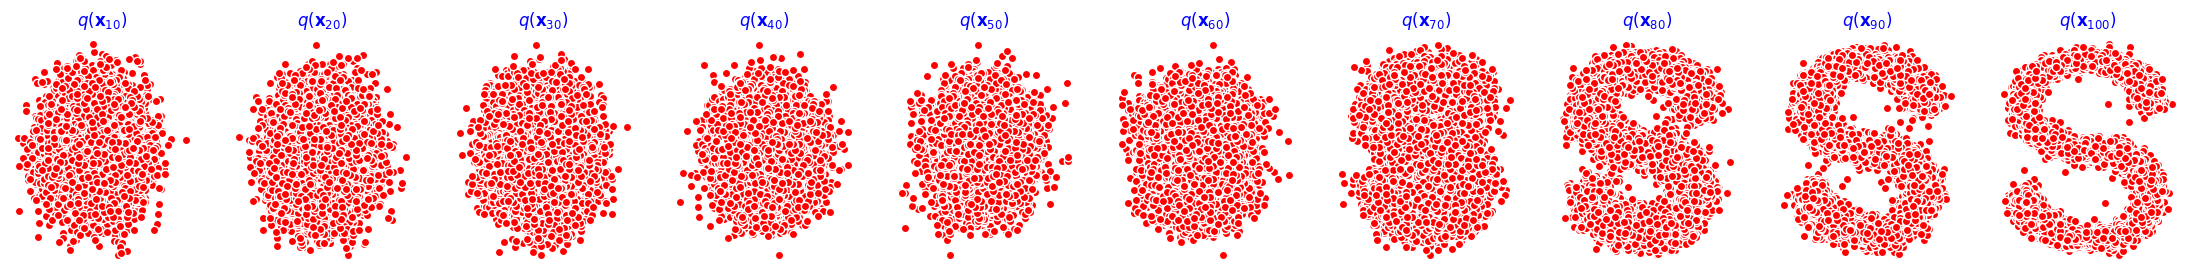

In [2]:
import numpy as np
import torch
import torch.nn as nn
import random
import os

from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

from models.ddpm.net import MLPDiffusion
from infras.misc import cprint


device = torch.device('cpu')
# device = torch.device('mps')

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


class DDPM(nn.Module):

    def __init__(
        self,
        s_dim,
        diff_steps,
        beta_min=1e-5,
        beta_max=5e-3,
        hidden_dim=128,
        hidden_layers=3,
    ):
        super().__init__()

        self.s_dim = s_dim
        self.diff_steps = diff_steps

        self.noise_net = MLPDiffusion(
            s_dim=self.s_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            n_steps=self.diff_steps,
        )

        betas = torch.linspace(-10,10,self.diff_steps)
        betas = torch.sigmoid(betas)*(beta_max-beta_min)+beta_min
        alphas = 1.0 - betas

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_bar', torch.cumprod(alphas,0))
        self.register_buffer('alphas_bar_sqrt', torch.sqrt(torch.cumprod(alphas,0)))
        self.register_buffer('one_minus_alphas_bar_sqrt', torch.sqrt(1.0-torch.cumprod(alphas,0)))

        self.register_buffer('dummy', torch.tensor([]))

    def forward_diffusion(self, x0, t):
        epsilon = torch.randn_like(x0).to(self.dummy.device)
        c_mean = self.alphas_bar_sqrt[t]
        c_std = self.one_minus_alphas_bar_sqrt[t]
        xt = x0*c_mean + epsilon*c_std   # reparam trick
        return xt

    def eval_noise_loss(self, x0):

        batch_size = x0.shape[0]

        t = torch.randint(0,self.diff_steps,size=(batch_size//2,))
        t = torch.cat([t,self.diff_steps-1-t],dim=0)

        coeff_x0 = self.alphas_bar_sqrt[t].reshape([-1,1])
        coeff_epsi = self.one_minus_alphas_bar_sqrt[t].reshape([-1,1])

        epsi = torch.randn_like(x0).to(self.dummy.device)
        x = x0*coeff_x0 + coeff_epsi*epsi

        pred = self.noise_net(x, t)
        err_noise = (epsi - pred).square().mean()

        return err_noise


    def _reverse_one_step(self, xt, t):
        # reverse one step to x_{t-1}
        assert type(t) == int
        t = torch.tensor(t).to(self.dummy.device)

        coeff_noise = self.betas[t]/self.one_minus_alphas_bar_sqrt[t]
        epsi_t = self.noise_net(xt, t)

        drift = torch.sqrt(1/self.alphas[t]) * (xt-coeff_noise*epsi_t)
        sigma_t = torch.sqrt(self.betas[t])
        z = torch.randn_like(xt).to(self.dummy.device)

        x_t_1 = drift + sigma_t*z
        return x_t_1

    def reverse_diffusion(self, xt):
        traj = [xt]
        for i in reversed(range(self.diff_steps)):
            xt = self._reverse_one_step(xt, i)
            traj.append(xt)
        #
        return traj




model = DDPM(
    s_dim=2,
    diff_steps=100,
).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data.shape)

# print(model.one_minus_alphas_bar_sqrt)

s_curve, _ = make_s_curve(10000, noise=0.1)
s_curve_2d = s_curve[:, [0,2]]/10.0
#
#
dataset = torch.Tensor(s_curve_2d).float().to(device)
#
#

# batch_size = 128
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
# #
# # # model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
# # # optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# #
# idx, batch_x = next(enumerate(dataloader))
# #
# model.eval_noise_loss(batch_x)
# model._reverse_one_step(batch_x, 1)

print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = model.eval_noise_loss(batch_x)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()

    if(t%100==0):
        print(loss)
        xt = torch.randn(dataset.shape).to(device)
        x_seq = model.reverse_diffusion(xt)

        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')



